In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
from tqdm import tqdm

In [2]:
data_dir = os.path.join(os.getcwd(), 'data')

img_dir = os.path.join(data_dir, 'images_test') #hfusg images of atopic dermatitis
mask_dir = os.path.join(data_dir, 'masks_test') #masks of SLEB layer

IMG_WIDTH, IMG_HEIGHT = 256, 256

In [3]:
X = []

#looping through image files
for file in tqdm(os.listdir(img_dir)):
    
    fullpath = os.path.join(img_dir, file)
    img = cv2.imread(fullpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resize images to the size of network input
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X.append(img)
    
print(img.shape)

100%|████████████████████████████████████████████████████████████████████████████| 3493/3493 [00:03<00:00, 1110.36it/s]


(256, 256, 3)


In [4]:
y = []

#looping through mask files
for file in tqdm(os.listdir(mask_dir)):
    
    fullpath = os.path.join(mask_dir, file)
    #getting into .mat file from matlab, where masks are storaged
    mat_file =  sio.loadmat(fullpath)
    mat_e= mat_file['E']
    mat_e= mat_e['e']
    mat_arrs = mat_e[0].ravel()
    arrs = mat_arrs[0]
    arr = arrs[0,0]['azs']
    #resize images to the size of network input
    arr = cv2.resize(arr, (IMG_WIDTH, IMG_HEIGHT))
    y.append(arr)

print(arr.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 3493/3493 [00:41<00:00, 83.61it/s]


(256, 256)


In [5]:
X, y = np.array(X), np.array(y)

print(X.shape)
print(y.shape)

(3493, 256, 256, 3)
(3493, 256, 256)


In [6]:
y = y.reshape((3493,256,256,1))

print(X.shape)
print(y.shape)

(3493, 256, 256, 3)
(3493, 256, 256, 1)


In [7]:
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
from tensorflow.keras import optimizers
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold


C:\Users\WD-X\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\WD-X\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\WD-X\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\WD-X\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\frame

In [8]:
smooth = 1.

#metric function Intersection over Union IoU (Jaccard Index)
def mean_iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


In [13]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH,  3))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

#output is a mask, size of 256x256
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 256, 256, 16) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 2320        dropout_18[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
dropout_26 (Dropout)            (None, 256, 256, 16) 0           conv2d_54[0][0]                  
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 16) 2320        dropout_26[0][0]                 
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 256, 256, 1)  17          conv2d_55[0][0]                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [10]:
#path for output network model
model_path = os.getcwd()+ '/unet.h5'

#checking learning progress
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

#early stoppage of epoch
earlystop = EarlyStopping(monitor = "val_loss", #val_loss 
                          min_delta = 0, 
                          patience = 8,
                          mode="min",
                          verbose = 1,
                          restore_best_weights = True)

#reducing learning rate value 
reducelr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=3, 
                              min_lr=0.0001, 
                              verbose=1)


#cross-validation setup
train_X = X
train_y = y
n_folds = 4 #determining how many folds will be created
history = []

skf = KFold(n_splits = n_folds)
for train_index, test_index in skf.split(train_X):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]

#fitting network
    results = model.fit(X_train, y_train,
                    batch_size=5, epochs=100, 
                    callbacks=[earlystop, checkpoint, reducelr],
                    validation_data=(X_test, y_test))
    history.append(results.history)

Train on 2619 samples, validate on 874 samples
Epoch 1/100


 920/2619 [=========>....................] - ETA: 46:45 - loss: 1.5287 - mean_iou: 0.143 - ETA: 24:43 - loss: 1.2214 - mean_iou: 0.151 - ETA: 17:21 - loss: 0.9958 - mean_iou: 0.131 - ETA: 13:39 - loss: 0.9527 - mean_iou: 0.128 - ETA: 11:25 - loss: 0.8409 - mean_iou: 0.113 - ETA: 9:57 - loss: 0.7744 - mean_iou: 0.104 - ETA: 8:53 - loss: 0.7481 - mean_iou: 0.10 - ETA: 8:05 - loss: 0.7134 - mean_iou: 0.10 - ETA: 7:28 - loss: 0.6858 - mean_iou: 0.11 - ETA: 6:58 - loss: 0.6526 - mean_iou: 0.11 - ETA: 6:34 - loss: 0.6228 - mean_iou: 0.11 - ETA: 6:13 - loss: 0.6283 - mean_iou: 0.11 - ETA: 5:56 - loss: 0.6023 - mean_iou: 0.11 - ETA: 5:41 - loss: 0.5814 - mean_iou: 0.11 - ETA: 5:28 - loss: 0.5677 - mean_iou: 0.11 - ETA: 5:17 - loss: 0.5491 - mean_iou: 0.12 - ETA: 5:07 - loss: 0.5307 - mean_iou: 0.13 - ETA: 4:58 - loss: 0.5117 - mean_iou: 0.14 - ETA: 4:50 - loss: 0.5180 - mean_iou: 0.14 - ETA: 4:43 - loss: 0.5151 - mean_iou: 0.16 - ETA: 4:36 - loss: 0.5114 - mean_iou: 0.16 - ETA: 4:30 - loss: 0.

 930/2619 [=========>....................] - ETA: 3:01 - loss: 0.0803 - mean_iou: 0.60 - ETA: 3:03 - loss: 0.0812 - mean_iou: 0.65 - ETA: 3:03 - loss: 0.0730 - mean_iou: 0.66 - ETA: 3:03 - loss: 0.0714 - mean_iou: 0.66 - ETA: 3:03 - loss: 0.0709 - mean_iou: 0.66 - ETA: 3:04 - loss: 0.0731 - mean_iou: 0.66 - ETA: 3:03 - loss: 0.0713 - mean_iou: 0.66 - ETA: 3:03 - loss: 0.0738 - mean_iou: 0.65 - ETA: 3:02 - loss: 0.0800 - mean_iou: 0.65 - ETA: 3:02 - loss: 0.0835 - mean_iou: 0.65 - ETA: 3:01 - loss: 0.0880 - mean_iou: 0.64 - ETA: 3:01 - loss: 0.0884 - mean_iou: 0.65 - ETA: 3:01 - loss: 0.0880 - mean_iou: 0.65 - ETA: 3:00 - loss: 0.0886 - mean_iou: 0.65 - ETA: 3:00 - loss: 0.0884 - mean_iou: 0.65 - ETA: 2:59 - loss: 0.0881 - mean_iou: 0.64 - ETA: 2:59 - loss: 0.0881 - mean_iou: 0.64 - ETA: 2:58 - loss: 0.0915 - mean_iou: 0.64 - ETA: 2:58 - loss: 0.0911 - mean_iou: 0.64 - ETA: 2:58 - loss: 0.0915 - mean_iou: 0.63 - ETA: 2:57 - loss: 0.0922 - mean_iou: 0.63 - ETA: 2:57 - loss: 0.0913 - mean

2615/2619 [============================>.] - ETA: 53s - loss: 0.0943 - mean_iou: 0.641 - ETA: 52s - loss: 0.0944 - mean_iou: 0.641 - ETA: 52s - loss: 0.0945 - mean_iou: 0.641 - ETA: 52s - loss: 0.0944 - mean_iou: 0.641 - ETA: 51s - loss: 0.0944 - mean_iou: 0.641 - ETA: 51s - loss: 0.0944 - mean_iou: 0.641 - ETA: 51s - loss: 0.0943 - mean_iou: 0.641 - ETA: 50s - loss: 0.0943 - mean_iou: 0.641 - ETA: 50s - loss: 0.0944 - mean_iou: 0.641 - ETA: 50s - loss: 0.0944 - mean_iou: 0.641 - ETA: 49s - loss: 0.0944 - mean_iou: 0.641 - ETA: 49s - loss: 0.0944 - mean_iou: 0.642 - ETA: 49s - loss: 0.0944 - mean_iou: 0.642 - ETA: 48s - loss: 0.0944 - mean_iou: 0.642 - ETA: 48s - loss: 0.0944 - mean_iou: 0.642 - ETA: 47s - loss: 0.0943 - mean_iou: 0.642 - ETA: 47s - loss: 0.0943 - mean_iou: 0.642 - ETA: 47s - loss: 0.0942 - mean_iou: 0.642 - ETA: 46s - loss: 0.0942 - mean_iou: 0.642 - ETA: 46s - loss: 0.0942 - mean_iou: 0.642 - ETA: 46s - loss: 0.0941 - mean_iou: 0.642 - ETA: 45s - loss: 0.0941 - mean_

 930/2619 [=========>....................] - ETA: 2:57 - loss: 0.0897 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0850 - mean_iou: 0.68 - ETA: 3:02 - loss: 0.0808 - mean_iou: 0.66 - ETA: 3:01 - loss: 0.0973 - mean_iou: 0.66 - ETA: 3:01 - loss: 0.0913 - mean_iou: 0.66 - ETA: 3:01 - loss: 0.0876 - mean_iou: 0.65 - ETA: 3:01 - loss: 0.0885 - mean_iou: 0.65 - ETA: 3:01 - loss: 0.0858 - mean_iou: 0.65 - ETA: 3:01 - loss: 0.0841 - mean_iou: 0.64 - ETA: 3:00 - loss: 0.0865 - mean_iou: 0.64 - ETA: 3:00 - loss: 0.0838 - mean_iou: 0.64 - ETA: 2:59 - loss: 0.0842 - mean_iou: 0.64 - ETA: 3:00 - loss: 0.0828 - mean_iou: 0.64 - ETA: 2:59 - loss: 0.0815 - mean_iou: 0.64 - ETA: 2:59 - loss: 0.0831 - mean_iou: 0.64 - ETA: 2:58 - loss: 0.0865 - mean_iou: 0.64 - ETA: 2:58 - loss: 0.0862 - mean_iou: 0.64 - ETA: 2:58 - loss: 0.0876 - mean_iou: 0.65 - ETA: 2:58 - loss: 0.0875 - mean_iou: 0.65 - ETA: 2:58 - loss: 0.0876 - mean_iou: 0.64 - ETA: 2:57 - loss: 0.0885 - mean_iou: 0.64 - ETA: 2:57 - loss: 0.0882 - mean

 930/2619 [=========>....................] - ETA: 2:59 - loss: 0.1277 - mean_iou: 0.71 - ETA: 3:02 - loss: 0.1212 - mean_iou: 0.70 - ETA: 3:03 - loss: 0.1011 - mean_iou: 0.66 - ETA: 3:03 - loss: 0.0950 - mean_iou: 0.64 - ETA: 3:03 - loss: 0.0991 - mean_iou: 0.64 - ETA: 3:02 - loss: 0.1045 - mean_iou: 0.65 - ETA: 3:02 - loss: 0.1036 - mean_iou: 0.66 - ETA: 3:01 - loss: 0.0993 - mean_iou: 0.65 - ETA: 3:01 - loss: 0.0970 - mean_iou: 0.63 - ETA: 3:00 - loss: 0.0965 - mean_iou: 0.64 - ETA: 3:00 - loss: 0.0946 - mean_iou: 0.64 - ETA: 2:59 - loss: 0.0954 - mean_iou: 0.64 - ETA: 2:59 - loss: 0.0953 - mean_iou: 0.64 - ETA: 2:59 - loss: 0.0947 - mean_iou: 0.64 - ETA: 2:59 - loss: 0.0955 - mean_iou: 0.65 - ETA: 2:59 - loss: 0.0974 - mean_iou: 0.65 - ETA: 2:58 - loss: 0.0965 - mean_iou: 0.65 - ETA: 2:58 - loss: 0.0965 - mean_iou: 0.65 - ETA: 2:57 - loss: 0.0962 - mean_iou: 0.64 - ETA: 2:57 - loss: 0.0953 - mean_iou: 0.65 - ETA: 2:56 - loss: 0.0962 - mean_iou: 0.64 - ETA: 2:56 - loss: 0.0960 - mean

2615/2619 [============================>.] - ETA: 53s - loss: 0.0739 - mean_iou: 0.690 - ETA: 52s - loss: 0.0739 - mean_iou: 0.690 - ETA: 52s - loss: 0.0739 - mean_iou: 0.690 - ETA: 52s - loss: 0.0738 - mean_iou: 0.690 - ETA: 51s - loss: 0.0738 - mean_iou: 0.690 - ETA: 51s - loss: 0.0738 - mean_iou: 0.690 - ETA: 51s - loss: 0.0738 - mean_iou: 0.690 - ETA: 50s - loss: 0.0738 - mean_iou: 0.690 - ETA: 50s - loss: 0.0738 - mean_iou: 0.690 - ETA: 50s - loss: 0.0737 - mean_iou: 0.690 - ETA: 49s - loss: 0.0737 - mean_iou: 0.690 - ETA: 49s - loss: 0.0737 - mean_iou: 0.690 - ETA: 49s - loss: 0.0736 - mean_iou: 0.690 - ETA: 48s - loss: 0.0736 - mean_iou: 0.691 - ETA: 48s - loss: 0.0736 - mean_iou: 0.691 - ETA: 48s - loss: 0.0737 - mean_iou: 0.690 - ETA: 47s - loss: 0.0736 - mean_iou: 0.690 - ETA: 47s - loss: 0.0737 - mean_iou: 0.690 - ETA: 46s - loss: 0.0736 - mean_iou: 0.691 - ETA: 46s - loss: 0.0736 - mean_iou: 0.690 - ETA: 46s - loss: 0.0736 - mean_iou: 0.690 - ETA: 45s - loss: 0.0735 - mean_

 930/2619 [=========>....................] - ETA: 2:57 - loss: 0.0761 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0778 - mean_iou: 0.73 - ETA: 3:00 - loss: 0.0701 - mean_iou: 0.72 - ETA: 3:00 - loss: 0.0685 - mean_iou: 0.70 - ETA: 3:00 - loss: 0.0710 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0702 - mean_iou: 0.70 - ETA: 3:00 - loss: 0.0681 - mean_iou: 0.70 - ETA: 3:00 - loss: 0.0677 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0686 - mean_iou: 0.70 - ETA: 3:00 - loss: 0.0672 - mean_iou: 0.69 - ETA: 3:00 - loss: 0.0702 - mean_iou: 0.69 - ETA: 2:59 - loss: 0.0691 - mean_iou: 0.69 - ETA: 2:59 - loss: 0.0680 - mean_iou: 0.69 - ETA: 2:58 - loss: 0.0703 - mean_iou: 0.69 - ETA: 2:58 - loss: 0.0699 - mean_iou: 0.69 - ETA: 2:58 - loss: 0.0691 - mean_iou: 0.69 - ETA: 2:58 - loss: 0.0682 - mean_iou: 0.69 - ETA: 2:58 - loss: 0.0688 - mean_iou: 0.69 - ETA: 2:57 - loss: 0.0683 - mean_iou: 0.69 - ETA: 2:57 - loss: 0.0680 - mean_iou: 0.69 - ETA: 2:57 - loss: 0.0673 - mean_iou: 0.69 - ETA: 2:56 - loss: 0.0675 - mean

 930/2619 [=========>....................] - ETA: 2:59 - loss: 0.0648 - mean_iou: 0.74 - ETA: 3:00 - loss: 0.0711 - mean_iou: 0.72 - ETA: 3:00 - loss: 0.0692 - mean_iou: 0.72 - ETA: 3:00 - loss: 0.0665 - mean_iou: 0.73 - ETA: 3:01 - loss: 0.0636 - mean_iou: 0.73 - ETA: 3:01 - loss: 0.0654 - mean_iou: 0.72 - ETA: 3:01 - loss: 0.0651 - mean_iou: 0.72 - ETA: 3:01 - loss: 0.0638 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0642 - mean_iou: 0.72 - ETA: 3:00 - loss: 0.0641 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0641 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0643 - mean_iou: 0.70 - ETA: 2:59 - loss: 0.0637 - mean_iou: 0.70 - ETA: 2:59 - loss: 0.0641 - mean_iou: 0.70 - ETA: 2:59 - loss: 0.0639 - mean_iou: 0.70 - ETA: 2:59 - loss: 0.0636 - mean_iou: 0.70 - ETA: 2:58 - loss: 0.0632 - mean_iou: 0.70 - ETA: 2:58 - loss: 0.0632 - mean_iou: 0.70 - ETA: 2:58 - loss: 0.0624 - mean_iou: 0.71 - ETA: 2:57 - loss: 0.0629 - mean_iou: 0.70 - ETA: 2:57 - loss: 0.0626 - mean_iou: 0.70 - ETA: 2:56 - loss: 0.0628 - mean

2615/2619 [============================>.] - ETA: 53s - loss: 0.0701 - mean_iou: 0.705 - ETA: 53s - loss: 0.0701 - mean_iou: 0.705 - ETA: 52s - loss: 0.0700 - mean_iou: 0.705 - ETA: 52s - loss: 0.0700 - mean_iou: 0.705 - ETA: 52s - loss: 0.0700 - mean_iou: 0.706 - ETA: 51s - loss: 0.0699 - mean_iou: 0.706 - ETA: 51s - loss: 0.0699 - mean_iou: 0.706 - ETA: 51s - loss: 0.0698 - mean_iou: 0.706 - ETA: 50s - loss: 0.0698 - mean_iou: 0.706 - ETA: 50s - loss: 0.0698 - mean_iou: 0.706 - ETA: 50s - loss: 0.0698 - mean_iou: 0.707 - ETA: 49s - loss: 0.0697 - mean_iou: 0.707 - ETA: 49s - loss: 0.0697 - mean_iou: 0.707 - ETA: 48s - loss: 0.0697 - mean_iou: 0.707 - ETA: 48s - loss: 0.0697 - mean_iou: 0.707 - ETA: 48s - loss: 0.0697 - mean_iou: 0.707 - ETA: 47s - loss: 0.0697 - mean_iou: 0.707 - ETA: 47s - loss: 0.0696 - mean_iou: 0.707 - ETA: 47s - loss: 0.0696 - mean_iou: 0.707 - ETA: 46s - loss: 0.0695 - mean_iou: 0.707 - ETA: 46s - loss: 0.0695 - mean_iou: 0.707 - ETA: 46s - loss: 0.0695 - mean_

 930/2619 [=========>....................] - ETA: 2:59 - loss: 0.0517 - mean_iou: 0.70 - ETA: 3:01 - loss: 0.0516 - mean_iou: 0.70 - ETA: 3:01 - loss: 0.0514 - mean_iou: 0.73 - ETA: 3:01 - loss: 0.0543 - mean_iou: 0.72 - ETA: 3:01 - loss: 0.0529 - mean_iou: 0.73 - ETA: 3:01 - loss: 0.0518 - mean_iou: 0.73 - ETA: 3:01 - loss: 0.0521 - mean_iou: 0.72 - ETA: 3:01 - loss: 0.0519 - mean_iou: 0.73 - ETA: 3:01 - loss: 0.0508 - mean_iou: 0.73 - ETA: 3:01 - loss: 0.0508 - mean_iou: 0.74 - ETA: 3:00 - loss: 0.0510 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0518 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0511 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0511 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0522 - mean_iou: 0.75 - ETA: 2:58 - loss: 0.0529 - mean_iou: 0.75 - ETA: 2:58 - loss: 0.0535 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0546 - mean_iou: 0.75 - ETA: 2:58 - loss: 0.0545 - mean_iou: 0.75 - ETA: 2:57 - loss: 0.0546 - mean_iou: 0.75 - ETA: 2:57 - loss: 0.0563 - mean_iou: 0.75 - ETA: 2:57 - loss: 0.0562 - mean

 930/2619 [=========>....................] - ETA: 2:59 - loss: 0.0406 - mean_iou: 0.73 - ETA: 3:00 - loss: 0.0480 - mean_iou: 0.74 - ETA: 3:01 - loss: 0.0480 - mean_iou: 0.76 - ETA: 3:01 - loss: 0.0502 - mean_iou: 0.76 - ETA: 3:01 - loss: 0.0485 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0499 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0492 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0488 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0489 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0486 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0492 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0497 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0494 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0489 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0485 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0490 - mean_iou: 0.75 - ETA: 2:58 - loss: 0.0504 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0500 - mean_iou: 0.75 - ETA: 2:58 - loss: 0.0498 - mean_iou: 0.76 - ETA: 2:57 - loss: 0.0499 - mean_iou: 0.76 - ETA: 2:57 - loss: 0.0496 - mean_iou: 0.76 - ETA: 2:56 - loss: 0.0495 - mean

2615/2619 [============================>.] - ETA: 53s - loss: 0.0476 - mean_iou: 0.775 - ETA: 53s - loss: 0.0476 - mean_iou: 0.775 - ETA: 52s - loss: 0.0476 - mean_iou: 0.775 - ETA: 52s - loss: 0.0477 - mean_iou: 0.775 - ETA: 51s - loss: 0.0477 - mean_iou: 0.775 - ETA: 51s - loss: 0.0476 - mean_iou: 0.775 - ETA: 51s - loss: 0.0479 - mean_iou: 0.775 - ETA: 50s - loss: 0.0481 - mean_iou: 0.775 - ETA: 50s - loss: 0.0481 - mean_iou: 0.774 - ETA: 50s - loss: 0.0482 - mean_iou: 0.774 - ETA: 49s - loss: 0.0482 - mean_iou: 0.774 - ETA: 49s - loss: 0.0483 - mean_iou: 0.773 - ETA: 49s - loss: 0.0483 - mean_iou: 0.773 - ETA: 48s - loss: 0.0483 - mean_iou: 0.773 - ETA: 48s - loss: 0.0484 - mean_iou: 0.773 - ETA: 48s - loss: 0.0484 - mean_iou: 0.773 - ETA: 47s - loss: 0.0485 - mean_iou: 0.772 - ETA: 47s - loss: 0.0485 - mean_iou: 0.772 - ETA: 47s - loss: 0.0485 - mean_iou: 0.772 - ETA: 46s - loss: 0.0485 - mean_iou: 0.772 - ETA: 46s - loss: 0.0486 - mean_iou: 0.772 - ETA: 45s - loss: 0.0486 - mean_

 930/2619 [=========>....................] - ETA: 3:00 - loss: 0.0543 - mean_iou: 0.82 - ETA: 3:02 - loss: 0.0579 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0545 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0527 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0515 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0505 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0500 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0502 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0486 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0477 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0479 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0469 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0472 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0469 - mean_iou: 0.76 - ETA: 2:59 - loss: 0.0464 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0464 - mean_iou: 0.77 - ETA: 2:58 - loss: 0.0461 - mean_iou: 0.77 - ETA: 2:58 - loss: 0.0461 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0462 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0463 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0462 - mean_iou: 0.78 - ETA: 2:57 - loss: 0.0461 - mean

 930/2619 [=========>....................] - ETA: 3:05 - loss: 0.0359 - mean_iou: 0.77 - ETA: 3:03 - loss: 0.0369 - mean_iou: 0.79 - ETA: 3:03 - loss: 0.0392 - mean_iou: 0.77 - ETA: 3:00 - loss: 0.0388 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0384 - mean_iou: 0.79 - ETA: 3:01 - loss: 0.0381 - mean_iou: 0.79 - ETA: 3:00 - loss: 0.0381 - mean_iou: 0.80 - ETA: 3:01 - loss: 0.0385 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0388 - mean_iou: 0.79 - ETA: 3:00 - loss: 0.0389 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0394 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0392 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0389 - mean_iou: 0.80 - ETA: 2:59 - loss: 0.0387 - mean_iou: 0.80 - ETA: 2:59 - loss: 0.0385 - mean_iou: 0.80 - ETA: 2:58 - loss: 0.0385 - mean_iou: 0.80 - ETA: 2:58 - loss: 0.0380 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0378 - mean_iou: 0.80 - ETA: 2:57 - loss: 0.0380 - mean_iou: 0.80 - ETA: 2:57 - loss: 0.0376 - mean_iou: 0.80 - ETA: 2:57 - loss: 0.0377 - mean_iou: 0.80 - ETA: 2:56 - loss: 0.0377 - mean

2615/2619 [============================>.] - ETA: 53s - loss: 0.0326 - mean_iou: 0.837 - ETA: 52s - loss: 0.0326 - mean_iou: 0.837 - ETA: 52s - loss: 0.0327 - mean_iou: 0.837 - ETA: 52s - loss: 0.0327 - mean_iou: 0.837 - ETA: 51s - loss: 0.0327 - mean_iou: 0.837 - ETA: 51s - loss: 0.0327 - mean_iou: 0.837 - ETA: 51s - loss: 0.0327 - mean_iou: 0.837 - ETA: 50s - loss: 0.0327 - mean_iou: 0.837 - ETA: 50s - loss: 0.0327 - mean_iou: 0.837 - ETA: 49s - loss: 0.0327 - mean_iou: 0.837 - ETA: 49s - loss: 0.0327 - mean_iou: 0.837 - ETA: 49s - loss: 0.0327 - mean_iou: 0.837 - ETA: 48s - loss: 0.0327 - mean_iou: 0.837 - ETA: 48s - loss: 0.0326 - mean_iou: 0.837 - ETA: 48s - loss: 0.0326 - mean_iou: 0.837 - ETA: 47s - loss: 0.0326 - mean_iou: 0.837 - ETA: 47s - loss: 0.0326 - mean_iou: 0.837 - ETA: 47s - loss: 0.0326 - mean_iou: 0.837 - ETA: 46s - loss: 0.0326 - mean_iou: 0.837 - ETA: 46s - loss: 0.0326 - mean_iou: 0.837 - ETA: 46s - loss: 0.0326 - mean_iou: 0.837 - ETA: 45s - loss: 0.0326 - mean_

 930/2619 [=========>....................] - ETA: 2:55 - loss: 0.0273 - mean_iou: 0.90 - ETA: 3:02 - loss: 0.0281 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0280 - mean_iou: 0.88 - ETA: 3:02 - loss: 0.0282 - mean_iou: 0.87 - ETA: 3:01 - loss: 0.0278 - mean_iou: 0.87 - ETA: 3:02 - loss: 0.0287 - mean_iou: 0.87 - ETA: 3:02 - loss: 0.0289 - mean_iou: 0.87 - ETA: 3:01 - loss: 0.0290 - mean_iou: 0.86 - ETA: 3:00 - loss: 0.0290 - mean_iou: 0.86 - ETA: 3:00 - loss: 0.0292 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0292 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0293 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0292 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0293 - mean_iou: 0.85 - ETA: 2:59 - loss: 0.0291 - mean_iou: 0.85 - ETA: 2:59 - loss: 0.0292 - mean_iou: 0.85 - ETA: 2:58 - loss: 0.0292 - mean_iou: 0.85 - ETA: 2:58 - loss: 0.0294 - mean_iou: 0.85 - ETA: 2:58 - loss: 0.0292 - mean_iou: 0.85 - ETA: 2:57 - loss: 0.0295 - mean_iou: 0.85 - ETA: 2:57 - loss: 0.0295 - mean_iou: 0.85 - ETA: 2:57 - loss: 0.0294 - mean

 930/2619 [=========>....................] - ETA: 2:59 - loss: 0.0263 - mean_iou: 0.86 - ETA: 3:00 - loss: 0.0291 - mean_iou: 0.84 - ETA: 3:00 - loss: 0.0272 - mean_iou: 0.84 - ETA: 3:00 - loss: 0.0269 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0268 - mean_iou: 0.84 - ETA: 3:00 - loss: 0.0262 - mean_iou: 0.84 - ETA: 3:00 - loss: 0.0258 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0259 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0261 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0258 - mean_iou: 0.85 - ETA: 2:59 - loss: 0.0262 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0262 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0263 - mean_iou: 0.85 - ETA: 2:58 - loss: 0.0265 - mean_iou: 0.85 - ETA: 2:58 - loss: 0.0264 - mean_iou: 0.86 - ETA: 2:58 - loss: 0.0265 - mean_iou: 0.86 - ETA: 2:57 - loss: 0.0267 - mean_iou: 0.85 - ETA: 2:57 - loss: 0.0267 - mean_iou: 0.85 - ETA: 2:57 - loss: 0.0266 - mean_iou: 0.85 - ETA: 2:57 - loss: 0.0264 - mean_iou: 0.85 - ETA: 2:56 - loss: 0.0265 - mean_iou: 0.86 - ETA: 2:56 - loss: 0.0264 - mean

2615/2619 [============================>.] - ETA: 53s - loss: 0.0266 - mean_iou: 0.865 - ETA: 52s - loss: 0.0266 - mean_iou: 0.865 - ETA: 52s - loss: 0.0266 - mean_iou: 0.865 - ETA: 52s - loss: 0.0266 - mean_iou: 0.865 - ETA: 51s - loss: 0.0266 - mean_iou: 0.865 - ETA: 51s - loss: 0.0266 - mean_iou: 0.865 - ETA: 51s - loss: 0.0266 - mean_iou: 0.865 - ETA: 50s - loss: 0.0266 - mean_iou: 0.865 - ETA: 50s - loss: 0.0266 - mean_iou: 0.865 - ETA: 50s - loss: 0.0266 - mean_iou: 0.865 - ETA: 49s - loss: 0.0266 - mean_iou: 0.865 - ETA: 49s - loss: 0.0266 - mean_iou: 0.865 - ETA: 49s - loss: 0.0266 - mean_iou: 0.865 - ETA: 48s - loss: 0.0266 - mean_iou: 0.865 - ETA: 48s - loss: 0.0266 - mean_iou: 0.865 - ETA: 47s - loss: 0.0266 - mean_iou: 0.865 - ETA: 47s - loss: 0.0266 - mean_iou: 0.865 - ETA: 47s - loss: 0.0266 - mean_iou: 0.865 - ETA: 46s - loss: 0.0266 - mean_iou: 0.865 - ETA: 46s - loss: 0.0266 - mean_iou: 0.865 - ETA: 46s - loss: 0.0266 - mean_iou: 0.865 - ETA: 45s - loss: 0.0266 - mean_

 930/2619 [=========>....................] - ETA: 3:00 - loss: 0.0202 - mean_iou: 0.89 - ETA: 3:03 - loss: 0.0254 - mean_iou: 0.87 - ETA: 3:03 - loss: 0.0249 - mean_iou: 0.88 - ETA: 3:03 - loss: 0.0242 - mean_iou: 0.88 - ETA: 3:02 - loss: 0.0243 - mean_iou: 0.88 - ETA: 3:02 - loss: 0.0243 - mean_iou: 0.88 - ETA: 3:01 - loss: 0.0260 - mean_iou: 0.87 - ETA: 3:01 - loss: 0.0258 - mean_iou: 0.87 - ETA: 3:00 - loss: 0.0258 - mean_iou: 0.88 - ETA: 3:00 - loss: 0.0254 - mean_iou: 0.88 - ETA: 3:00 - loss: 0.0254 - mean_iou: 0.87 - ETA: 3:00 - loss: 0.0254 - mean_iou: 0.88 - ETA: 3:00 - loss: 0.0255 - mean_iou: 0.87 - ETA: 2:59 - loss: 0.0253 - mean_iou: 0.87 - ETA: 2:59 - loss: 0.0253 - mean_iou: 0.87 - ETA: 2:59 - loss: 0.0252 - mean_iou: 0.87 - ETA: 2:58 - loss: 0.0252 - mean_iou: 0.87 - ETA: 2:58 - loss: 0.0252 - mean_iou: 0.87 - ETA: 2:57 - loss: 0.0252 - mean_iou: 0.87 - ETA: 2:57 - loss: 0.0253 - mean_iou: 0.87 - ETA: 2:57 - loss: 0.0252 - mean_iou: 0.87 - ETA: 2:57 - loss: 0.0252 - mean

 930/2619 [=========>....................] - ETA: 2:59 - loss: 0.0236 - mean_iou: 0.88 - ETA: 3:00 - loss: 0.0238 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0229 - mean_iou: 0.87 - ETA: 3:01 - loss: 0.0236 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0237 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0232 - mean_iou: 0.86 - ETA: 3:01 - loss: 0.0233 - mean_iou: 0.86 - ETA: 3:01 - loss: 0.0231 - mean_iou: 0.85 - ETA: 3:01 - loss: 0.0232 - mean_iou: 0.86 - ETA: 3:01 - loss: 0.0232 - mean_iou: 0.86 - ETA: 3:00 - loss: 0.0246 - mean_iou: 0.86 - ETA: 3:00 - loss: 0.0246 - mean_iou: 0.86 - ETA: 3:00 - loss: 0.0248 - mean_iou: 0.86 - ETA: 3:00 - loss: 0.0247 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0244 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0245 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0243 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0242 - mean_iou: 0.86 - ETA: 2:58 - loss: 0.0242 - mean_iou: 0.86 - ETA: 2:58 - loss: 0.0241 - mean_iou: 0.86 - ETA: 2:57 - loss: 0.0240 - mean_iou: 0.86 - ETA: 2:57 - loss: 0.0240 - mean

2615/2619 [============================>.] - ETA: 53s - loss: 0.0234 - mean_iou: 0.880 - ETA: 52s - loss: 0.0234 - mean_iou: 0.880 - ETA: 52s - loss: 0.0234 - mean_iou: 0.880 - ETA: 52s - loss: 0.0234 - mean_iou: 0.880 - ETA: 51s - loss: 0.0234 - mean_iou: 0.880 - ETA: 51s - loss: 0.0234 - mean_iou: 0.880 - ETA: 51s - loss: 0.0234 - mean_iou: 0.880 - ETA: 50s - loss: 0.0234 - mean_iou: 0.880 - ETA: 50s - loss: 0.0234 - mean_iou: 0.880 - ETA: 50s - loss: 0.0234 - mean_iou: 0.880 - ETA: 49s - loss: 0.0234 - mean_iou: 0.880 - ETA: 49s - loss: 0.0234 - mean_iou: 0.880 - ETA: 49s - loss: 0.0234 - mean_iou: 0.880 - ETA: 48s - loss: 0.0234 - mean_iou: 0.880 - ETA: 48s - loss: 0.0234 - mean_iou: 0.880 - ETA: 48s - loss: 0.0234 - mean_iou: 0.880 - ETA: 47s - loss: 0.0233 - mean_iou: 0.880 - ETA: 47s - loss: 0.0233 - mean_iou: 0.880 - ETA: 46s - loss: 0.0233 - mean_iou: 0.880 - ETA: 46s - loss: 0.0233 - mean_iou: 0.880 - ETA: 46s - loss: 0.0233 - mean_iou: 0.881 - ETA: 45s - loss: 0.0233 - mean_

 930/2620 [=========>....................] - ETA: 2:59 - loss: 0.0590 - mean_iou: 0.66 - ETA: 3:01 - loss: 0.0615 - mean_iou: 0.69 - ETA: 3:01 - loss: 0.0607 - mean_iou: 0.68 - ETA: 3:01 - loss: 0.0598 - mean_iou: 0.69 - ETA: 3:01 - loss: 0.0593 - mean_iou: 0.69 - ETA: 3:01 - loss: 0.0584 - mean_iou: 0.68 - ETA: 3:01 - loss: 0.0607 - mean_iou: 0.70 - ETA: 3:01 - loss: 0.0603 - mean_iou: 0.69 - ETA: 3:01 - loss: 0.0609 - mean_iou: 0.69 - ETA: 3:01 - loss: 0.0629 - mean_iou: 0.68 - ETA: 3:00 - loss: 0.0628 - mean_iou: 0.68 - ETA: 3:00 - loss: 0.0628 - mean_iou: 0.68 - ETA: 3:00 - loss: 0.0632 - mean_iou: 0.68 - ETA: 3:00 - loss: 0.0635 - mean_iou: 0.68 - ETA: 3:00 - loss: 0.0643 - mean_iou: 0.68 - ETA: 2:59 - loss: 0.0630 - mean_iou: 0.69 - ETA: 2:59 - loss: 0.0627 - mean_iou: 0.70 - ETA: 2:59 - loss: 0.0630 - mean_iou: 0.70 - ETA: 2:59 - loss: 0.0632 - mean_iou: 0.70 - ETA: 2:58 - loss: 0.0636 - mean_iou: 0.69 - ETA: 2:58 - loss: 0.0637 - mean_iou: 0.69 - ETA: 2:57 - loss: 0.0638 - mean

 930/2620 [=========>....................] - ETA: 3:01 - loss: 0.0477 - mean_iou: 0.72 - ETA: 3:03 - loss: 0.0499 - mean_iou: 0.72 - ETA: 3:03 - loss: 0.0496 - mean_iou: 0.72 - ETA: 3:04 - loss: 0.0492 - mean_iou: 0.72 - ETA: 3:04 - loss: 0.0495 - mean_iou: 0.73 - ETA: 3:03 - loss: 0.0488 - mean_iou: 0.73 - ETA: 3:03 - loss: 0.0519 - mean_iou: 0.72 - ETA: 3:02 - loss: 0.0531 - mean_iou: 0.73 - ETA: 3:02 - loss: 0.0539 - mean_iou: 0.71 - ETA: 3:02 - loss: 0.0538 - mean_iou: 0.71 - ETA: 3:02 - loss: 0.0527 - mean_iou: 0.71 - ETA: 3:02 - loss: 0.0527 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0535 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0528 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0523 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0521 - mean_iou: 0.72 - ETA: 3:00 - loss: 0.0524 - mean_iou: 0.72 - ETA: 2:59 - loss: 0.0519 - mean_iou: 0.72 - ETA: 2:59 - loss: 0.0521 - mean_iou: 0.72 - ETA: 2:59 - loss: 0.0525 - mean_iou: 0.72 - ETA: 2:58 - loss: 0.0523 - mean_iou: 0.72 - ETA: 2:58 - loss: 0.0520 - mean

2615/2620 [============================>.] - ETA: 54s - loss: 0.0516 - mean_iou: 0.739 - ETA: 53s - loss: 0.0516 - mean_iou: 0.739 - ETA: 53s - loss: 0.0516 - mean_iou: 0.739 - ETA: 53s - loss: 0.0516 - mean_iou: 0.739 - ETA: 52s - loss: 0.0516 - mean_iou: 0.739 - ETA: 52s - loss: 0.0516 - mean_iou: 0.739 - ETA: 52s - loss: 0.0516 - mean_iou: 0.739 - ETA: 51s - loss: 0.0516 - mean_iou: 0.739 - ETA: 51s - loss: 0.0516 - mean_iou: 0.739 - ETA: 51s - loss: 0.0516 - mean_iou: 0.739 - ETA: 50s - loss: 0.0516 - mean_iou: 0.739 - ETA: 50s - loss: 0.0516 - mean_iou: 0.739 - ETA: 49s - loss: 0.0515 - mean_iou: 0.739 - ETA: 49s - loss: 0.0515 - mean_iou: 0.739 - ETA: 49s - loss: 0.0515 - mean_iou: 0.739 - ETA: 48s - loss: 0.0515 - mean_iou: 0.739 - ETA: 48s - loss: 0.0515 - mean_iou: 0.739 - ETA: 48s - loss: 0.0515 - mean_iou: 0.740 - ETA: 47s - loss: 0.0514 - mean_iou: 0.740 - ETA: 47s - loss: 0.0515 - mean_iou: 0.740 - ETA: 47s - loss: 0.0515 - mean_iou: 0.740 - ETA: 46s - loss: 0.0515 - mean_

 930/2620 [=========>....................] - ETA: 3:01 - loss: 0.0503 - mean_iou: 0.72 - ETA: 3:05 - loss: 0.0516 - mean_iou: 0.72 - ETA: 3:05 - loss: 0.0511 - mean_iou: 0.74 - ETA: 3:05 - loss: 0.0506 - mean_iou: 0.75 - ETA: 3:05 - loss: 0.0529 - mean_iou: 0.75 - ETA: 3:05 - loss: 0.0546 - mean_iou: 0.75 - ETA: 3:04 - loss: 0.0524 - mean_iou: 0.77 - ETA: 3:04 - loss: 0.0514 - mean_iou: 0.75 - ETA: 3:04 - loss: 0.0507 - mean_iou: 0.76 - ETA: 3:03 - loss: 0.0502 - mean_iou: 0.75 - ETA: 3:03 - loss: 0.0496 - mean_iou: 0.75 - ETA: 3:03 - loss: 0.0495 - mean_iou: 0.75 - ETA: 3:03 - loss: 0.0494 - mean_iou: 0.75 - ETA: 3:03 - loss: 0.0491 - mean_iou: 0.74 - ETA: 3:03 - loss: 0.0491 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0492 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0492 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0488 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0489 - mean_iou: 0.74 - ETA: 3:00 - loss: 0.0488 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0487 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0487 - mean

 930/2620 [=========>....................] - ETA: 3:02 - loss: 0.0444 - mean_iou: 0.73 - ETA: 3:03 - loss: 0.0463 - mean_iou: 0.72 - ETA: 3:03 - loss: 0.0480 - mean_iou: 0.74 - ETA: 3:03 - loss: 0.0467 - mean_iou: 0.73 - ETA: 3:02 - loss: 0.0458 - mean_iou: 0.74 - ETA: 3:01 - loss: 0.0458 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0470 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0465 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0455 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0458 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0455 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0457 - mean_iou: 0.76 - ETA: 3:01 - loss: 0.0457 - mean_iou: 0.76 - ETA: 3:01 - loss: 0.0455 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0456 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0453 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0459 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0460 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0455 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0451 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0450 - mean_iou: 0.75 - ETA: 2:58 - loss: 0.0447 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0441 - mean_iou: 0.769 - ETA: 53s - loss: 0.0441 - mean_iou: 0.769 - ETA: 52s - loss: 0.0441 - mean_iou: 0.769 - ETA: 52s - loss: 0.0441 - mean_iou: 0.769 - ETA: 52s - loss: 0.0441 - mean_iou: 0.769 - ETA: 51s - loss: 0.0441 - mean_iou: 0.769 - ETA: 51s - loss: 0.0442 - mean_iou: 0.769 - ETA: 51s - loss: 0.0442 - mean_iou: 0.769 - ETA: 50s - loss: 0.0441 - mean_iou: 0.769 - ETA: 50s - loss: 0.0441 - mean_iou: 0.769 - ETA: 50s - loss: 0.0441 - mean_iou: 0.769 - ETA: 49s - loss: 0.0441 - mean_iou: 0.769 - ETA: 49s - loss: 0.0441 - mean_iou: 0.769 - ETA: 48s - loss: 0.0441 - mean_iou: 0.769 - ETA: 48s - loss: 0.0441 - mean_iou: 0.769 - ETA: 48s - loss: 0.0441 - mean_iou: 0.769 - ETA: 47s - loss: 0.0441 - mean_iou: 0.769 - ETA: 47s - loss: 0.0441 - mean_iou: 0.770 - ETA: 47s - loss: 0.0441 - mean_iou: 0.770 - ETA: 46s - loss: 0.0441 - mean_iou: 0.770 - ETA: 46s - loss: 0.0441 - mean_iou: 0.770 - ETA: 46s - loss: 0.0441 - mean_

 930/2620 [=========>....................] - ETA: 3:00 - loss: 0.0499 - mean_iou: 0.76 - ETA: 3:03 - loss: 0.0452 - mean_iou: 0.76 - ETA: 3:03 - loss: 0.0426 - mean_iou: 0.77 - ETA: 3:04 - loss: 0.0413 - mean_iou: 0.77 - ETA: 3:04 - loss: 0.0412 - mean_iou: 0.78 - ETA: 3:05 - loss: 0.0436 - mean_iou: 0.78 - ETA: 3:05 - loss: 0.0436 - mean_iou: 0.77 - ETA: 3:04 - loss: 0.0428 - mean_iou: 0.78 - ETA: 3:04 - loss: 0.0427 - mean_iou: 0.77 - ETA: 3:04 - loss: 0.0422 - mean_iou: 0.77 - ETA: 3:04 - loss: 0.0422 - mean_iou: 0.77 - ETA: 3:03 - loss: 0.0428 - mean_iou: 0.77 - ETA: 3:03 - loss: 0.0426 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0425 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0421 - mean_iou: 0.77 - ETA: 3:01 - loss: 0.0418 - mean_iou: 0.77 - ETA: 3:01 - loss: 0.0419 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0420 - mean_iou: 0.77 - ETA: 3:00 - loss: 0.0420 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0417 - mean_iou: 0.76 - ETA: 2:59 - loss: 0.0415 - mean_iou: 0.76 - ETA: 2:59 - loss: 0.0414 - mean

 930/2620 [=========>....................] - ETA: 3:01 - loss: 0.0325 - mean_iou: 0.80 - ETA: 3:02 - loss: 0.0349 - mean_iou: 0.81 - ETA: 3:02 - loss: 0.0368 - mean_iou: 0.80 - ETA: 3:02 - loss: 0.0394 - mean_iou: 0.80 - ETA: 3:02 - loss: 0.0415 - mean_iou: 0.79 - ETA: 3:02 - loss: 0.0403 - mean_iou: 0.79 - ETA: 3:02 - loss: 0.0395 - mean_iou: 0.79 - ETA: 3:02 - loss: 0.0388 - mean_iou: 0.79 - ETA: 3:02 - loss: 0.0387 - mean_iou: 0.80 - ETA: 3:02 - loss: 0.0385 - mean_iou: 0.80 - ETA: 3:01 - loss: 0.0384 - mean_iou: 0.80 - ETA: 3:01 - loss: 0.0382 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0387 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0390 - mean_iou: 0.81 - ETA: 3:00 - loss: 0.0392 - mean_iou: 0.81 - ETA: 2:59 - loss: 0.0389 - mean_iou: 0.81 - ETA: 2:59 - loss: 0.0392 - mean_iou: 0.81 - ETA: 2:59 - loss: 0.0389 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0389 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0390 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0389 - mean_iou: 0.81 - ETA: 2:57 - loss: 0.0387 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0381 - mean_iou: 0.799 - ETA: 53s - loss: 0.0381 - mean_iou: 0.799 - ETA: 52s - loss: 0.0381 - mean_iou: 0.799 - ETA: 52s - loss: 0.0381 - mean_iou: 0.799 - ETA: 52s - loss: 0.0381 - mean_iou: 0.799 - ETA: 51s - loss: 0.0381 - mean_iou: 0.799 - ETA: 51s - loss: 0.0381 - mean_iou: 0.799 - ETA: 51s - loss: 0.0381 - mean_iou: 0.799 - ETA: 50s - loss: 0.0381 - mean_iou: 0.799 - ETA: 50s - loss: 0.0381 - mean_iou: 0.800 - ETA: 50s - loss: 0.0381 - mean_iou: 0.800 - ETA: 49s - loss: 0.0381 - mean_iou: 0.800 - ETA: 49s - loss: 0.0381 - mean_iou: 0.800 - ETA: 48s - loss: 0.0381 - mean_iou: 0.800 - ETA: 48s - loss: 0.0381 - mean_iou: 0.800 - ETA: 48s - loss: 0.0381 - mean_iou: 0.800 - ETA: 47s - loss: 0.0381 - mean_iou: 0.800 - ETA: 47s - loss: 0.0381 - mean_iou: 0.800 - ETA: 47s - loss: 0.0381 - mean_iou: 0.800 - ETA: 46s - loss: 0.0381 - mean_iou: 0.799 - ETA: 46s - loss: 0.0381 - mean_iou: 0.800 - ETA: 46s - loss: 0.0381 - mean_

 930/2620 [=========>....................] - ETA: 3:02 - loss: 0.0301 - mean_iou: 0.83 - ETA: 3:04 - loss: 0.0338 - mean_iou: 0.80 - ETA: 3:10 - loss: 0.0358 - mean_iou: 0.81 - ETA: 3:11 - loss: 0.0369 - mean_iou: 0.82 - ETA: 3:12 - loss: 0.0366 - mean_iou: 0.82 - ETA: 3:11 - loss: 0.0362 - mean_iou: 0.81 - ETA: 3:10 - loss: 0.0369 - mean_iou: 0.81 - ETA: 3:10 - loss: 0.0363 - mean_iou: 0.81 - ETA: 3:09 - loss: 0.0365 - mean_iou: 0.81 - ETA: 3:09 - loss: 0.0363 - mean_iou: 0.81 - ETA: 3:08 - loss: 0.0362 - mean_iou: 0.81 - ETA: 3:08 - loss: 0.0360 - mean_iou: 0.81 - ETA: 3:08 - loss: 0.0361 - mean_iou: 0.81 - ETA: 3:08 - loss: 0.0360 - mean_iou: 0.81 - ETA: 3:07 - loss: 0.0357 - mean_iou: 0.81 - ETA: 3:08 - loss: 0.0354 - mean_iou: 0.81 - ETA: 3:07 - loss: 0.0359 - mean_iou: 0.81 - ETA: 3:07 - loss: 0.0359 - mean_iou: 0.81 - ETA: 3:07 - loss: 0.0355 - mean_iou: 0.81 - ETA: 3:06 - loss: 0.0357 - mean_iou: 0.81 - ETA: 3:05 - loss: 0.0357 - mean_iou: 0.81 - ETA: 3:05 - loss: 0.0358 - mean

 930/2620 [=========>....................] - ETA: 2:59 - loss: 0.0379 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.0334 - mean_iou: 0.79 - ETA: 3:00 - loss: 0.0315 - mean_iou: 0.79 - ETA: 3:00 - loss: 0.0325 - mean_iou: 0.79 - ETA: 3:00 - loss: 0.0327 - mean_iou: 0.79 - ETA: 3:01 - loss: 0.0320 - mean_iou: 0.79 - ETA: 3:01 - loss: 0.0338 - mean_iou: 0.79 - ETA: 3:01 - loss: 0.0340 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0336 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0334 - mean_iou: 0.81 - ETA: 3:00 - loss: 0.0329 - mean_iou: 0.81 - ETA: 2:59 - loss: 0.0328 - mean_iou: 0.81 - ETA: 2:59 - loss: 0.0325 - mean_iou: 0.81 - ETA: 2:59 - loss: 0.0327 - mean_iou: 0.81 - ETA: 2:59 - loss: 0.0326 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0326 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0324 - mean_iou: 0.82 - ETA: 2:58 - loss: 0.0329 - mean_iou: 0.82 - ETA: 2:57 - loss: 0.0332 - mean_iou: 0.82 - ETA: 2:57 - loss: 0.0331 - mean_iou: 0.82 - ETA: 2:57 - loss: 0.0331 - mean_iou: 0.81 - ETA: 2:56 - loss: 0.0331 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0334 - mean_iou: 0.819 - ETA: 53s - loss: 0.0334 - mean_iou: 0.820 - ETA: 52s - loss: 0.0334 - mean_iou: 0.820 - ETA: 52s - loss: 0.0334 - mean_iou: 0.819 - ETA: 52s - loss: 0.0334 - mean_iou: 0.819 - ETA: 51s - loss: 0.0334 - mean_iou: 0.819 - ETA: 51s - loss: 0.0334 - mean_iou: 0.819 - ETA: 51s - loss: 0.0334 - mean_iou: 0.819 - ETA: 50s - loss: 0.0334 - mean_iou: 0.819 - ETA: 50s - loss: 0.0334 - mean_iou: 0.819 - ETA: 49s - loss: 0.0334 - mean_iou: 0.819 - ETA: 49s - loss: 0.0334 - mean_iou: 0.819 - ETA: 49s - loss: 0.0334 - mean_iou: 0.819 - ETA: 48s - loss: 0.0334 - mean_iou: 0.820 - ETA: 48s - loss: 0.0334 - mean_iou: 0.820 - ETA: 48s - loss: 0.0334 - mean_iou: 0.820 - ETA: 47s - loss: 0.0334 - mean_iou: 0.820 - ETA: 47s - loss: 0.0334 - mean_iou: 0.820 - ETA: 47s - loss: 0.0334 - mean_iou: 0.820 - ETA: 46s - loss: 0.0334 - mean_iou: 0.820 - ETA: 46s - loss: 0.0334 - mean_iou: 0.820 - ETA: 46s - loss: 0.0334 - mean_

 930/2620 [=========>....................] - ETA: 3:01 - loss: 0.0289 - mean_iou: 0.88 - ETA: 3:03 - loss: 0.0286 - mean_iou: 0.83 - ETA: 3:05 - loss: 0.0297 - mean_iou: 0.81 - ETA: 3:05 - loss: 0.0304 - mean_iou: 0.81 - ETA: 3:04 - loss: 0.0304 - mean_iou: 0.80 - ETA: 3:04 - loss: 0.0309 - mean_iou: 0.81 - ETA: 3:04 - loss: 0.0312 - mean_iou: 0.80 - ETA: 3:03 - loss: 0.0303 - mean_iou: 0.81 - ETA: 3:03 - loss: 0.0310 - mean_iou: 0.82 - ETA: 3:02 - loss: 0.0306 - mean_iou: 0.81 - ETA: 3:02 - loss: 0.0304 - mean_iou: 0.82 - ETA: 3:02 - loss: 0.0304 - mean_iou: 0.82 - ETA: 3:01 - loss: 0.0308 - mean_iou: 0.82 - ETA: 3:01 - loss: 0.0308 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.0308 - mean_iou: 0.82 - ETA: 3:01 - loss: 0.0309 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.0308 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.0307 - mean_iou: 0.83 - ETA: 3:00 - loss: 0.0308 - mean_iou: 0.83 - ETA: 2:59 - loss: 0.0307 - mean_iou: 0.83 - ETA: 2:59 - loss: 0.0306 - mean_iou: 0.83 - ETA: 2:59 - loss: 0.0308 - mean

 930/2620 [=========>....................] - ETA: 3:01 - loss: 0.0495 - mean_iou: 0.74 - ETA: 3:02 - loss: 0.0482 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0489 - mean_iou: 0.74 - ETA: 3:02 - loss: 0.0519 - mean_iou: 0.73 - ETA: 3:02 - loss: 0.0548 - mean_iou: 0.72 - ETA: 3:02 - loss: 0.0566 - mean_iou: 0.72 - ETA: 3:01 - loss: 0.0595 - mean_iou: 0.72 - ETA: 3:01 - loss: 0.0579 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0577 - mean_iou: 0.72 - ETA: 3:01 - loss: 0.0564 - mean_iou: 0.72 - ETA: 3:01 - loss: 0.0574 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0567 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0567 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0558 - mean_iou: 0.71 - ETA: 2:59 - loss: 0.0562 - mean_iou: 0.71 - ETA: 2:59 - loss: 0.0558 - mean_iou: 0.71 - ETA: 2:58 - loss: 0.0559 - mean_iou: 0.71 - ETA: 2:58 - loss: 0.0556 - mean_iou: 0.71 - ETA: 2:58 - loss: 0.0557 - mean_iou: 0.71 - ETA: 2:58 - loss: 0.0570 - mean_iou: 0.71 - ETA: 2:57 - loss: 0.0570 - mean_iou: 0.70 - ETA: 2:57 - loss: 0.0572 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0543 - mean_iou: 0.736 - ETA: 53s - loss: 0.0543 - mean_iou: 0.736 - ETA: 52s - loss: 0.0543 - mean_iou: 0.736 - ETA: 52s - loss: 0.0543 - mean_iou: 0.736 - ETA: 52s - loss: 0.0543 - mean_iou: 0.736 - ETA: 51s - loss: 0.0543 - mean_iou: 0.736 - ETA: 51s - loss: 0.0542 - mean_iou: 0.736 - ETA: 51s - loss: 0.0542 - mean_iou: 0.736 - ETA: 50s - loss: 0.0542 - mean_iou: 0.736 - ETA: 50s - loss: 0.0543 - mean_iou: 0.736 - ETA: 50s - loss: 0.0543 - mean_iou: 0.736 - ETA: 49s - loss: 0.0543 - mean_iou: 0.736 - ETA: 49s - loss: 0.0543 - mean_iou: 0.736 - ETA: 49s - loss: 0.0543 - mean_iou: 0.736 - ETA: 48s - loss: 0.0543 - mean_iou: 0.736 - ETA: 48s - loss: 0.0542 - mean_iou: 0.736 - ETA: 47s - loss: 0.0542 - mean_iou: 0.736 - ETA: 47s - loss: 0.0543 - mean_iou: 0.736 - ETA: 47s - loss: 0.0543 - mean_iou: 0.737 - ETA: 46s - loss: 0.0542 - mean_iou: 0.737 - ETA: 46s - loss: 0.0542 - mean_iou: 0.737 - ETA: 46s - loss: 0.0542 - mean_

 930/2620 [=========>....................] - ETA: 2:58 - loss: 0.0568 - mean_iou: 0.67 - ETA: 3:00 - loss: 0.0507 - mean_iou: 0.70 - ETA: 3:01 - loss: 0.0543 - mean_iou: 0.72 - ETA: 3:00 - loss: 0.0529 - mean_iou: 0.73 - ETA: 3:00 - loss: 0.0528 - mean_iou: 0.72 - ETA: 3:00 - loss: 0.0518 - mean_iou: 0.73 - ETA: 3:00 - loss: 0.0519 - mean_iou: 0.73 - ETA: 3:00 - loss: 0.0518 - mean_iou: 0.73 - ETA: 3:00 - loss: 0.0525 - mean_iou: 0.74 - ETA: 2:59 - loss: 0.0517 - mean_iou: 0.74 - ETA: 2:59 - loss: 0.0510 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0504 - mean_iou: 0.74 - ETA: 2:59 - loss: 0.0497 - mean_iou: 0.75 - ETA: 2:58 - loss: 0.0508 - mean_iou: 0.74 - ETA: 2:58 - loss: 0.0503 - mean_iou: 0.75 - ETA: 2:58 - loss: 0.0503 - mean_iou: 0.74 - ETA: 2:57 - loss: 0.0500 - mean_iou: 0.74 - ETA: 2:57 - loss: 0.0499 - mean_iou: 0.74 - ETA: 2:57 - loss: 0.0493 - mean_iou: 0.75 - ETA: 2:56 - loss: 0.0500 - mean_iou: 0.75 - ETA: 2:56 - loss: 0.0497 - mean_iou: 0.75 - ETA: 2:56 - loss: 0.0501 - mean

 930/2620 [=========>....................] - ETA: 3:02 - loss: 0.0529 - mean_iou: 0.77 - ETA: 3:03 - loss: 0.0451 - mean_iou: 0.77 - ETA: 3:04 - loss: 0.0445 - mean_iou: 0.78 - ETA: 3:04 - loss: 0.0464 - mean_iou: 0.78 - ETA: 3:03 - loss: 0.0461 - mean_iou: 0.78 - ETA: 3:02 - loss: 0.0452 - mean_iou: 0.78 - ETA: 3:02 - loss: 0.0444 - mean_iou: 0.78 - ETA: 3:02 - loss: 0.0445 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0451 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0456 - mean_iou: 0.77 - ETA: 3:01 - loss: 0.0454 - mean_iou: 0.76 - ETA: 3:01 - loss: 0.0460 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0458 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0458 - mean_iou: 0.76 - ETA: 2:59 - loss: 0.0454 - mean_iou: 0.77 - ETA: 2:59 - loss: 0.0454 - mean_iou: 0.77 - ETA: 2:59 - loss: 0.0454 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0451 - mean_iou: 0.77 - ETA: 2:58 - loss: 0.0450 - mean_iou: 0.77 - ETA: 2:58 - loss: 0.0453 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0455 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0460 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0466 - mean_iou: 0.766 - ETA: 52s - loss: 0.0467 - mean_iou: 0.766 - ETA: 52s - loss: 0.0467 - mean_iou: 0.766 - ETA: 52s - loss: 0.0467 - mean_iou: 0.766 - ETA: 51s - loss: 0.0467 - mean_iou: 0.766 - ETA: 51s - loss: 0.0467 - mean_iou: 0.765 - ETA: 51s - loss: 0.0466 - mean_iou: 0.765 - ETA: 50s - loss: 0.0466 - mean_iou: 0.765 - ETA: 50s - loss: 0.0466 - mean_iou: 0.765 - ETA: 50s - loss: 0.0466 - mean_iou: 0.765 - ETA: 49s - loss: 0.0466 - mean_iou: 0.765 - ETA: 49s - loss: 0.0466 - mean_iou: 0.765 - ETA: 48s - loss: 0.0466 - mean_iou: 0.766 - ETA: 48s - loss: 0.0466 - mean_iou: 0.766 - ETA: 48s - loss: 0.0466 - mean_iou: 0.766 - ETA: 47s - loss: 0.0466 - mean_iou: 0.766 - ETA: 47s - loss: 0.0466 - mean_iou: 0.765 - ETA: 47s - loss: 0.0466 - mean_iou: 0.766 - ETA: 46s - loss: 0.0466 - mean_iou: 0.766 - ETA: 46s - loss: 0.0466 - mean_iou: 0.766 - ETA: 46s - loss: 0.0466 - mean_iou: 0.766 - ETA: 45s - loss: 0.0466 - mean_

 930/2620 [=========>....................] - ETA: 3:02 - loss: 0.0392 - mean_iou: 0.77 - ETA: 3:03 - loss: 0.0419 - mean_iou: 0.73 - ETA: 3:03 - loss: 0.0399 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0392 - mean_iou: 0.74 - ETA: 3:02 - loss: 0.0396 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0419 - mean_iou: 0.76 - ETA: 3:01 - loss: 0.0421 - mean_iou: 0.76 - ETA: 3:01 - loss: 0.0437 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0443 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0438 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0430 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0428 - mean_iou: 0.77 - ETA: 2:59 - loss: 0.0428 - mean_iou: 0.77 - ETA: 2:59 - loss: 0.0433 - mean_iou: 0.77 - ETA: 2:59 - loss: 0.0430 - mean_iou: 0.77 - ETA: 2:58 - loss: 0.0434 - mean_iou: 0.77 - ETA: 2:58 - loss: 0.0437 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0440 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0440 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0436 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0435 - mean_iou: 0.77 - ETA: 2:56 - loss: 0.0430 - mean

 930/2620 [=========>....................] - ETA: 3:01 - loss: 0.0429 - mean_iou: 0.75 - ETA: 3:03 - loss: 0.0468 - mean_iou: 0.73 - ETA: 3:03 - loss: 0.0449 - mean_iou: 0.74 - ETA: 3:03 - loss: 0.0438 - mean_iou: 0.76 - ETA: 3:03 - loss: 0.0440 - mean_iou: 0.75 - ETA: 3:03 - loss: 0.0468 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0461 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0450 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0445 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0447 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0442 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0439 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0441 - mean_iou: 0.77 - ETA: 3:00 - loss: 0.0440 - mean_iou: 0.77 - ETA: 2:59 - loss: 0.0440 - mean_iou: 0.76 - ETA: 2:59 - loss: 0.0437 - mean_iou: 0.76 - ETA: 2:59 - loss: 0.0439 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0436 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0439 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0436 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0432 - mean_iou: 0.77 - ETA: 2:57 - loss: 0.0435 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0412 - mean_iou: 0.785 - ETA: 53s - loss: 0.0412 - mean_iou: 0.785 - ETA: 52s - loss: 0.0412 - mean_iou: 0.785 - ETA: 52s - loss: 0.0411 - mean_iou: 0.786 - ETA: 52s - loss: 0.0411 - mean_iou: 0.785 - ETA: 51s - loss: 0.0411 - mean_iou: 0.785 - ETA: 51s - loss: 0.0411 - mean_iou: 0.785 - ETA: 51s - loss: 0.0411 - mean_iou: 0.786 - ETA: 50s - loss: 0.0411 - mean_iou: 0.786 - ETA: 50s - loss: 0.0411 - mean_iou: 0.786 - ETA: 49s - loss: 0.0411 - mean_iou: 0.786 - ETA: 49s - loss: 0.0411 - mean_iou: 0.786 - ETA: 49s - loss: 0.0411 - mean_iou: 0.786 - ETA: 48s - loss: 0.0411 - mean_iou: 0.786 - ETA: 48s - loss: 0.0411 - mean_iou: 0.786 - ETA: 48s - loss: 0.0411 - mean_iou: 0.786 - ETA: 47s - loss: 0.0411 - mean_iou: 0.786 - ETA: 47s - loss: 0.0411 - mean_iou: 0.786 - ETA: 47s - loss: 0.0411 - mean_iou: 0.786 - ETA: 46s - loss: 0.0411 - mean_iou: 0.786 - ETA: 46s - loss: 0.0411 - mean_iou: 0.786 - ETA: 46s - loss: 0.0411 - mean_

 930/2620 [=========>....................] - ETA: 3:00 - loss: 0.0403 - mean_iou: 0.75 - ETA: 3:01 - loss: 0.0388 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0391 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0388 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0384 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0377 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0380 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0388 - mean_iou: 0.78 - ETA: 3:00 - loss: 0.0382 - mean_iou: 0.78 - ETA: 3:00 - loss: 0.0408 - mean_iou: 0.78 - ETA: 3:00 - loss: 0.0408 - mean_iou: 0.78 - ETA: 2:59 - loss: 0.0407 - mean_iou: 0.77 - ETA: 2:59 - loss: 0.0399 - mean_iou: 0.78 - ETA: 2:59 - loss: 0.0397 - mean_iou: 0.78 - ETA: 2:59 - loss: 0.0397 - mean_iou: 0.78 - ETA: 2:58 - loss: 0.0392 - mean_iou: 0.78 - ETA: 2:58 - loss: 0.0394 - mean_iou: 0.78 - ETA: 2:58 - loss: 0.0393 - mean_iou: 0.78 - ETA: 2:57 - loss: 0.0394 - mean_iou: 0.78 - ETA: 2:57 - loss: 0.0393 - mean_iou: 0.78 - ETA: 2:56 - loss: 0.0392 - mean_iou: 0.78 - ETA: 2:56 - loss: 0.0389 - mean

 930/2620 [=========>....................] - ETA: 2:58 - loss: 0.0387 - mean_iou: 0.83 - ETA: 3:00 - loss: 0.0382 - mean_iou: 0.83 - ETA: 3:00 - loss: 0.0400 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.0398 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0390 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0380 - mean_iou: 0.81 - ETA: 3:00 - loss: 0.0378 - mean_iou: 0.81 - ETA: 3:00 - loss: 0.0379 - mean_iou: 0.79 - ETA: 3:00 - loss: 0.0372 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0371 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0372 - mean_iou: 0.80 - ETA: 2:59 - loss: 0.0369 - mean_iou: 0.80 - ETA: 2:59 - loss: 0.0368 - mean_iou: 0.80 - ETA: 2:59 - loss: 0.0362 - mean_iou: 0.80 - ETA: 2:58 - loss: 0.0363 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0365 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0365 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0365 - mean_iou: 0.81 - ETA: 2:57 - loss: 0.0363 - mean_iou: 0.81 - ETA: 2:57 - loss: 0.0363 - mean_iou: 0.81 - ETA: 2:57 - loss: 0.0363 - mean_iou: 0.81 - ETA: 2:56 - loss: 0.0364 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0363 - mean_iou: 0.810 - ETA: 52s - loss: 0.0363 - mean_iou: 0.810 - ETA: 52s - loss: 0.0363 - mean_iou: 0.810 - ETA: 52s - loss: 0.0363 - mean_iou: 0.809 - ETA: 51s - loss: 0.0363 - mean_iou: 0.809 - ETA: 51s - loss: 0.0363 - mean_iou: 0.810 - ETA: 51s - loss: 0.0362 - mean_iou: 0.810 - ETA: 50s - loss: 0.0362 - mean_iou: 0.810 - ETA: 50s - loss: 0.0362 - mean_iou: 0.809 - ETA: 50s - loss: 0.0362 - mean_iou: 0.809 - ETA: 49s - loss: 0.0362 - mean_iou: 0.809 - ETA: 49s - loss: 0.0362 - mean_iou: 0.809 - ETA: 49s - loss: 0.0362 - mean_iou: 0.809 - ETA: 48s - loss: 0.0362 - mean_iou: 0.809 - ETA: 48s - loss: 0.0362 - mean_iou: 0.809 - ETA: 48s - loss: 0.0362 - mean_iou: 0.810 - ETA: 47s - loss: 0.0362 - mean_iou: 0.810 - ETA: 47s - loss: 0.0362 - mean_iou: 0.810 - ETA: 46s - loss: 0.0362 - mean_iou: 0.810 - ETA: 46s - loss: 0.0362 - mean_iou: 0.810 - ETA: 46s - loss: 0.0362 - mean_iou: 0.810 - ETA: 45s - loss: 0.0362 - mean_

 930/2620 [=========>....................] - ETA: 2:59 - loss: 0.0331 - mean_iou: 0.80 - ETA: 3:01 - loss: 0.0321 - mean_iou: 0.85 - ETA: 3:01 - loss: 0.0318 - mean_iou: 0.86 - ETA: 3:01 - loss: 0.0330 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0324 - mean_iou: 0.84 - ETA: 3:01 - loss: 0.0334 - mean_iou: 0.83 - ETA: 3:01 - loss: 0.0334 - mean_iou: 0.83 - ETA: 3:01 - loss: 0.0333 - mean_iou: 0.83 - ETA: 3:01 - loss: 0.0329 - mean_iou: 0.83 - ETA: 3:01 - loss: 0.0331 - mean_iou: 0.83 - ETA: 3:00 - loss: 0.0330 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.0329 - mean_iou: 0.82 - ETA: 2:59 - loss: 0.0329 - mean_iou: 0.83 - ETA: 2:59 - loss: 0.0329 - mean_iou: 0.83 - ETA: 2:59 - loss: 0.0331 - mean_iou: 0.83 - ETA: 2:58 - loss: 0.0335 - mean_iou: 0.82 - ETA: 2:58 - loss: 0.0336 - mean_iou: 0.82 - ETA: 2:58 - loss: 0.0339 - mean_iou: 0.82 - ETA: 2:58 - loss: 0.0341 - mean_iou: 0.82 - ETA: 2:57 - loss: 0.0342 - mean_iou: 0.82 - ETA: 2:57 - loss: 0.0338 - mean_iou: 0.82 - ETA: 2:57 - loss: 0.0339 - mean

 930/2620 [=========>....................] - ETA: 3:00 - loss: 0.0292 - mean_iou: 0.79 - ETA: 3:02 - loss: 0.0349 - mean_iou: 0.82 - ETA: 3:02 - loss: 0.0346 - mean_iou: 0.81 - ETA: 3:03 - loss: 0.0342 - mean_iou: 0.81 - ETA: 3:03 - loss: 0.0336 - mean_iou: 0.82 - ETA: 3:03 - loss: 0.0330 - mean_iou: 0.82 - ETA: 3:03 - loss: 0.0327 - mean_iou: 0.82 - ETA: 3:02 - loss: 0.0328 - mean_iou: 0.82 - ETA: 3:02 - loss: 0.0321 - mean_iou: 0.83 - ETA: 3:01 - loss: 0.0323 - mean_iou: 0.82 - ETA: 3:01 - loss: 0.0326 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.0321 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.0319 - mean_iou: 0.83 - ETA: 3:00 - loss: 0.0319 - mean_iou: 0.83 - ETA: 2:59 - loss: 0.0321 - mean_iou: 0.82 - ETA: 2:59 - loss: 0.0325 - mean_iou: 0.82 - ETA: 2:59 - loss: 0.0326 - mean_iou: 0.82 - ETA: 2:58 - loss: 0.0329 - mean_iou: 0.82 - ETA: 2:58 - loss: 0.0329 - mean_iou: 0.83 - ETA: 2:58 - loss: 0.0331 - mean_iou: 0.83 - ETA: 2:57 - loss: 0.0329 - mean_iou: 0.83 - ETA: 2:57 - loss: 0.0327 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0323 - mean_iou: 0.829 - ETA: 53s - loss: 0.0323 - mean_iou: 0.829 - ETA: 52s - loss: 0.0323 - mean_iou: 0.829 - ETA: 52s - loss: 0.0323 - mean_iou: 0.829 - ETA: 51s - loss: 0.0323 - mean_iou: 0.829 - ETA: 51s - loss: 0.0322 - mean_iou: 0.829 - ETA: 51s - loss: 0.0322 - mean_iou: 0.829 - ETA: 50s - loss: 0.0322 - mean_iou: 0.829 - ETA: 50s - loss: 0.0322 - mean_iou: 0.829 - ETA: 50s - loss: 0.0322 - mean_iou: 0.829 - ETA: 49s - loss: 0.0322 - mean_iou: 0.829 - ETA: 49s - loss: 0.0322 - mean_iou: 0.829 - ETA: 49s - loss: 0.0322 - mean_iou: 0.829 - ETA: 48s - loss: 0.0322 - mean_iou: 0.829 - ETA: 48s - loss: 0.0322 - mean_iou: 0.829 - ETA: 48s - loss: 0.0322 - mean_iou: 0.829 - ETA: 47s - loss: 0.0322 - mean_iou: 0.829 - ETA: 47s - loss: 0.0322 - mean_iou: 0.829 - ETA: 47s - loss: 0.0322 - mean_iou: 0.829 - ETA: 46s - loss: 0.0322 - mean_iou: 0.830 - ETA: 46s - loss: 0.0322 - mean_iou: 0.830 - ETA: 45s - loss: 0.0322 - mean_

 930/2620 [=========>....................] - ETA: 3:00 - loss: 0.0573 - mean_iou: 0.80 - ETA: 3:01 - loss: 0.0579 - mean_iou: 0.74 - ETA: 3:01 - loss: 0.0558 - mean_iou: 0.72 - ETA: 3:02 - loss: 0.0536 - mean_iou: 0.73 - ETA: 3:02 - loss: 0.0520 - mean_iou: 0.72 - ETA: 3:03 - loss: 0.0503 - mean_iou: 0.73 - ETA: 3:03 - loss: 0.0501 - mean_iou: 0.72 - ETA: 3:02 - loss: 0.0505 - mean_iou: 0.71 - ETA: 3:02 - loss: 0.0502 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0508 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0509 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0511 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0509 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0526 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0525 - mean_iou: 0.70 - ETA: 3:00 - loss: 0.0543 - mean_iou: 0.70 - ETA: 3:00 - loss: 0.0542 - mean_iou: 0.70 - ETA: 2:59 - loss: 0.0544 - mean_iou: 0.70 - ETA: 2:59 - loss: 0.0546 - mean_iou: 0.70 - ETA: 2:58 - loss: 0.0546 - mean_iou: 0.70 - ETA: 2:58 - loss: 0.0545 - mean_iou: 0.70 - ETA: 2:58 - loss: 0.0543 - mean

 930/2620 [=========>....................] - ETA: 3:00 - loss: 0.0504 - mean_iou: 0.72 - ETA: 3:02 - loss: 0.0444 - mean_iou: 0.71 - ETA: 3:03 - loss: 0.0464 - mean_iou: 0.74 - ETA: 3:03 - loss: 0.0505 - mean_iou: 0.73 - ETA: 3:02 - loss: 0.0502 - mean_iou: 0.72 - ETA: 3:03 - loss: 0.0517 - mean_iou: 0.72 - ETA: 3:02 - loss: 0.0519 - mean_iou: 0.70 - ETA: 3:02 - loss: 0.0505 - mean_iou: 0.70 - ETA: 3:02 - loss: 0.0522 - mean_iou: 0.69 - ETA: 3:02 - loss: 0.0518 - mean_iou: 0.69 - ETA: 3:03 - loss: 0.0507 - mean_iou: 0.69 - ETA: 3:03 - loss: 0.0511 - mean_iou: 0.70 - ETA: 3:03 - loss: 0.0510 - mean_iou: 0.70 - ETA: 3:03 - loss: 0.0508 - mean_iou: 0.70 - ETA: 3:03 - loss: 0.0510 - mean_iou: 0.70 - ETA: 3:03 - loss: 0.0509 - mean_iou: 0.70 - ETA: 3:02 - loss: 0.0507 - mean_iou: 0.71 - ETA: 3:02 - loss: 0.0511 - mean_iou: 0.71 - ETA: 3:02 - loss: 0.0506 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0507 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0510 - mean_iou: 0.71 - ETA: 3:01 - loss: 0.0507 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0475 - mean_iou: 0.734 - ETA: 53s - loss: 0.0475 - mean_iou: 0.734 - ETA: 53s - loss: 0.0475 - mean_iou: 0.734 - ETA: 52s - loss: 0.0475 - mean_iou: 0.734 - ETA: 52s - loss: 0.0475 - mean_iou: 0.734 - ETA: 52s - loss: 0.0475 - mean_iou: 0.734 - ETA: 51s - loss: 0.0475 - mean_iou: 0.734 - ETA: 51s - loss: 0.0475 - mean_iou: 0.734 - ETA: 51s - loss: 0.0474 - mean_iou: 0.734 - ETA: 50s - loss: 0.0474 - mean_iou: 0.734 - ETA: 50s - loss: 0.0474 - mean_iou: 0.734 - ETA: 50s - loss: 0.0474 - mean_iou: 0.734 - ETA: 49s - loss: 0.0474 - mean_iou: 0.734 - ETA: 49s - loss: 0.0474 - mean_iou: 0.734 - ETA: 48s - loss: 0.0474 - mean_iou: 0.734 - ETA: 48s - loss: 0.0474 - mean_iou: 0.734 - ETA: 48s - loss: 0.0474 - mean_iou: 0.734 - ETA: 47s - loss: 0.0473 - mean_iou: 0.734 - ETA: 47s - loss: 0.0473 - mean_iou: 0.734 - ETA: 47s - loss: 0.0473 - mean_iou: 0.734 - ETA: 46s - loss: 0.0474 - mean_iou: 0.734 - ETA: 46s - loss: 0.0474 - mean_

 930/2620 [=========>....................] - ETA: 2:59 - loss: 0.0477 - mean_iou: 0.73 - ETA: 3:01 - loss: 0.0451 - mean_iou: 0.72 - ETA: 3:01 - loss: 0.0459 - mean_iou: 0.72 - ETA: 3:01 - loss: 0.0445 - mean_iou: 0.73 - ETA: 3:01 - loss: 0.0442 - mean_iou: 0.73 - ETA: 3:00 - loss: 0.0444 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0456 - mean_iou: 0.74 - ETA: 3:00 - loss: 0.0459 - mean_iou: 0.74 - ETA: 3:00 - loss: 0.0469 - mean_iou: 0.74 - ETA: 3:00 - loss: 0.0463 - mean_iou: 0.74 - ETA: 3:00 - loss: 0.0459 - mean_iou: 0.74 - ETA: 3:00 - loss: 0.0462 - mean_iou: 0.73 - ETA: 2:59 - loss: 0.0459 - mean_iou: 0.74 - ETA: 2:59 - loss: 0.0455 - mean_iou: 0.74 - ETA: 2:59 - loss: 0.0457 - mean_iou: 0.74 - ETA: 2:58 - loss: 0.0455 - mean_iou: 0.73 - ETA: 2:58 - loss: 0.0457 - mean_iou: 0.73 - ETA: 2:57 - loss: 0.0454 - mean_iou: 0.73 - ETA: 2:57 - loss: 0.0451 - mean_iou: 0.73 - ETA: 2:57 - loss: 0.0454 - mean_iou: 0.73 - ETA: 2:57 - loss: 0.0455 - mean_iou: 0.73 - ETA: 2:56 - loss: 0.0455 - mean

 930/2620 [=========>....................] - ETA: 3:01 - loss: 0.0388 - mean_iou: 0.81 - ETA: 3:03 - loss: 0.0428 - mean_iou: 0.77 - ETA: 3:04 - loss: 0.0404 - mean_iou: 0.76 - ETA: 3:04 - loss: 0.0436 - mean_iou: 0.77 - ETA: 3:04 - loss: 0.0426 - mean_iou: 0.76 - ETA: 3:05 - loss: 0.0424 - mean_iou: 0.78 - ETA: 3:04 - loss: 0.0438 - mean_iou: 0.78 - ETA: 3:04 - loss: 0.0438 - mean_iou: 0.79 - ETA: 3:03 - loss: 0.0437 - mean_iou: 0.78 - ETA: 3:03 - loss: 0.0436 - mean_iou: 0.78 - ETA: 3:02 - loss: 0.0433 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0432 - mean_iou: 0.77 - ETA: 3:01 - loss: 0.0428 - mean_iou: 0.77 - ETA: 3:01 - loss: 0.0429 - mean_iou: 0.77 - ETA: 3:01 - loss: 0.0428 - mean_iou: 0.77 - ETA: 3:00 - loss: 0.0426 - mean_iou: 0.77 - ETA: 3:00 - loss: 0.0425 - mean_iou: 0.77 - ETA: 2:59 - loss: 0.0424 - mean_iou: 0.77 - ETA: 2:59 - loss: 0.0429 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0427 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0425 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.0427 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0418 - mean_iou: 0.758 - ETA: 53s - loss: 0.0418 - mean_iou: 0.758 - ETA: 52s - loss: 0.0418 - mean_iou: 0.758 - ETA: 52s - loss: 0.0418 - mean_iou: 0.758 - ETA: 52s - loss: 0.0418 - mean_iou: 0.758 - ETA: 51s - loss: 0.0418 - mean_iou: 0.758 - ETA: 51s - loss: 0.0418 - mean_iou: 0.758 - ETA: 51s - loss: 0.0419 - mean_iou: 0.758 - ETA: 50s - loss: 0.0418 - mean_iou: 0.758 - ETA: 50s - loss: 0.0418 - mean_iou: 0.758 - ETA: 50s - loss: 0.0418 - mean_iou: 0.758 - ETA: 49s - loss: 0.0418 - mean_iou: 0.758 - ETA: 49s - loss: 0.0418 - mean_iou: 0.758 - ETA: 48s - loss: 0.0419 - mean_iou: 0.758 - ETA: 48s - loss: 0.0419 - mean_iou: 0.759 - ETA: 48s - loss: 0.0419 - mean_iou: 0.758 - ETA: 47s - loss: 0.0418 - mean_iou: 0.759 - ETA: 47s - loss: 0.0418 - mean_iou: 0.759 - ETA: 47s - loss: 0.0418 - mean_iou: 0.759 - ETA: 46s - loss: 0.0418 - mean_iou: 0.759 - ETA: 46s - loss: 0.0418 - mean_iou: 0.759 - ETA: 46s - loss: 0.0418 - mean_

 930/2620 [=========>....................] - ETA: 3:01 - loss: 0.0416 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0416 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0413 - mean_iou: 0.73 - ETA: 3:03 - loss: 0.0432 - mean_iou: 0.73 - ETA: 3:04 - loss: 0.0420 - mean_iou: 0.73 - ETA: 3:04 - loss: 0.0412 - mean_iou: 0.74 - ETA: 3:04 - loss: 0.0409 - mean_iou: 0.74 - ETA: 3:03 - loss: 0.0405 - mean_iou: 0.74 - ETA: 3:03 - loss: 0.0407 - mean_iou: 0.74 - ETA: 3:02 - loss: 0.0414 - mean_iou: 0.74 - ETA: 3:02 - loss: 0.0410 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0409 - mean_iou: 0.75 - ETA: 3:03 - loss: 0.0409 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0410 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0405 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.0407 - mean_iou: 0.76 - ETA: 3:01 - loss: 0.0408 - mean_iou: 0.76 - ETA: 3:01 - loss: 0.0407 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0412 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0412 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.0410 - mean_iou: 0.76 - ETA: 2:59 - loss: 0.0408 - mean

 930/2620 [=========>....................] - ETA: 3:01 - loss: 0.0373 - mean_iou: 0.81 - ETA: 3:02 - loss: 0.0418 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0403 - mean_iou: 0.79 - ETA: 3:01 - loss: 0.0402 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0395 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0384 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0377 - mean_iou: 0.77 - ETA: 3:02 - loss: 0.0371 - mean_iou: 0.77 - ETA: 3:01 - loss: 0.0373 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0373 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0373 - mean_iou: 0.78 - ETA: 3:00 - loss: 0.0375 - mean_iou: 0.78 - ETA: 3:00 - loss: 0.0379 - mean_iou: 0.78 - ETA: 3:00 - loss: 0.0377 - mean_iou: 0.78 - ETA: 2:59 - loss: 0.0377 - mean_iou: 0.79 - ETA: 2:59 - loss: 0.0375 - mean_iou: 0.79 - ETA: 2:59 - loss: 0.0376 - mean_iou: 0.79 - ETA: 2:58 - loss: 0.0380 - mean_iou: 0.79 - ETA: 2:58 - loss: 0.0377 - mean_iou: 0.78 - ETA: 2:58 - loss: 0.0378 - mean_iou: 0.78 - ETA: 2:58 - loss: 0.0376 - mean_iou: 0.78 - ETA: 2:57 - loss: 0.0373 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0370 - mean_iou: 0.785 - ETA: 52s - loss: 0.0370 - mean_iou: 0.785 - ETA: 52s - loss: 0.0370 - mean_iou: 0.785 - ETA: 52s - loss: 0.0370 - mean_iou: 0.785 - ETA: 51s - loss: 0.0370 - mean_iou: 0.785 - ETA: 51s - loss: 0.0370 - mean_iou: 0.785 - ETA: 51s - loss: 0.0370 - mean_iou: 0.785 - ETA: 50s - loss: 0.0370 - mean_iou: 0.785 - ETA: 50s - loss: 0.0370 - mean_iou: 0.785 - ETA: 50s - loss: 0.0371 - mean_iou: 0.785 - ETA: 49s - loss: 0.0371 - mean_iou: 0.785 - ETA: 49s - loss: 0.0371 - mean_iou: 0.785 - ETA: 49s - loss: 0.0371 - mean_iou: 0.785 - ETA: 48s - loss: 0.0371 - mean_iou: 0.785 - ETA: 48s - loss: 0.0371 - mean_iou: 0.785 - ETA: 48s - loss: 0.0371 - mean_iou: 0.785 - ETA: 47s - loss: 0.0371 - mean_iou: 0.784 - ETA: 47s - loss: 0.0371 - mean_iou: 0.784 - ETA: 46s - loss: 0.0371 - mean_iou: 0.784 - ETA: 46s - loss: 0.0371 - mean_iou: 0.784 - ETA: 46s - loss: 0.0371 - mean_iou: 0.784 - ETA: 45s - loss: 0.0371 - mean_

 930/2620 [=========>....................] - ETA: 3:00 - loss: 0.0364 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0350 - mean_iou: 0.80 - ETA: 3:02 - loss: 0.0331 - mean_iou: 0.81 - ETA: 3:01 - loss: 0.0329 - mean_iou: 0.80 - ETA: 3:01 - loss: 0.0357 - mean_iou: 0.80 - ETA: 3:01 - loss: 0.0351 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0348 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0361 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0355 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0353 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.0350 - mean_iou: 0.81 - ETA: 3:00 - loss: 0.0348 - mean_iou: 0.80 - ETA: 2:59 - loss: 0.0346 - mean_iou: 0.80 - ETA: 2:59 - loss: 0.0347 - mean_iou: 0.80 - ETA: 2:59 - loss: 0.0344 - mean_iou: 0.80 - ETA: 2:58 - loss: 0.0343 - mean_iou: 0.80 - ETA: 2:58 - loss: 0.0341 - mean_iou: 0.80 - ETA: 2:57 - loss: 0.0339 - mean_iou: 0.80 - ETA: 2:57 - loss: 0.0339 - mean_iou: 0.80 - ETA: 2:57 - loss: 0.0341 - mean_iou: 0.80 - ETA: 2:57 - loss: 0.0341 - mean_iou: 0.80 - ETA: 2:56 - loss: 0.0340 - mean

 930/2620 [=========>....................] - ETA: 3:00 - loss: 0.0295 - mean_iou: 0.81 - ETA: 3:01 - loss: 0.0301 - mean_iou: 0.81 - ETA: 3:01 - loss: 0.0322 - mean_iou: 0.79 - ETA: 3:01 - loss: 0.0322 - mean_iou: 0.79 - ETA: 3:00 - loss: 0.0332 - mean_iou: 0.77 - ETA: 3:01 - loss: 0.0334 - mean_iou: 0.77 - ETA: 3:01 - loss: 0.0333 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0332 - mean_iou: 0.77 - ETA: 3:01 - loss: 0.0334 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0335 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0332 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0332 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0330 - mean_iou: 0.78 - ETA: 3:01 - loss: 0.0329 - mean_iou: 0.78 - ETA: 3:00 - loss: 0.0327 - mean_iou: 0.79 - ETA: 3:00 - loss: 0.0326 - mean_iou: 0.79 - ETA: 3:00 - loss: 0.0325 - mean_iou: 0.79 - ETA: 2:59 - loss: 0.0325 - mean_iou: 0.79 - ETA: 2:59 - loss: 0.0324 - mean_iou: 0.79 - ETA: 2:58 - loss: 0.0324 - mean_iou: 0.79 - ETA: 2:58 - loss: 0.0322 - mean_iou: 0.80 - ETA: 2:58 - loss: 0.0322 - mean

2615/2620 [============================>.] - ETA: 53s - loss: 0.0329 - mean_iou: 0.805 - ETA: 53s - loss: 0.0329 - mean_iou: 0.805 - ETA: 52s - loss: 0.0329 - mean_iou: 0.805 - ETA: 52s - loss: 0.0329 - mean_iou: 0.805 - ETA: 52s - loss: 0.0329 - mean_iou: 0.805 - ETA: 51s - loss: 0.0329 - mean_iou: 0.805 - ETA: 51s - loss: 0.0329 - mean_iou: 0.805 - ETA: 50s - loss: 0.0329 - mean_iou: 0.805 - ETA: 50s - loss: 0.0329 - mean_iou: 0.805 - ETA: 50s - loss: 0.0329 - mean_iou: 0.805 - ETA: 49s - loss: 0.0329 - mean_iou: 0.805 - ETA: 49s - loss: 0.0329 - mean_iou: 0.805 - ETA: 49s - loss: 0.0329 - mean_iou: 0.805 - ETA: 48s - loss: 0.0329 - mean_iou: 0.805 - ETA: 48s - loss: 0.0329 - mean_iou: 0.805 - ETA: 48s - loss: 0.0329 - mean_iou: 0.805 - ETA: 47s - loss: 0.0329 - mean_iou: 0.805 - ETA: 47s - loss: 0.0329 - mean_iou: 0.805 - ETA: 47s - loss: 0.0329 - mean_iou: 0.805 - ETA: 46s - loss: 0.0329 - mean_iou: 0.805 - ETA: 46s - loss: 0.0329 - mean_iou: 0.805 - ETA: 46s - loss: 0.0329 - mean_

 930/2620 [=========>....................] - ETA: 3:01 - loss: 0.0382 - mean_iou: 0.87 - ETA: 3:03 - loss: 0.0335 - mean_iou: 0.87 - ETA: 3:03 - loss: 0.0347 - mean_iou: 0.84 - ETA: 3:02 - loss: 0.0359 - mean_iou: 0.82 - ETA: 3:02 - loss: 0.0347 - mean_iou: 0.83 - ETA: 3:01 - loss: 0.0347 - mean_iou: 0.82 - ETA: 3:01 - loss: 0.0341 - mean_iou: 0.81 - ETA: 3:00 - loss: 0.0339 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.0334 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.0338 - mean_iou: 0.81 - ETA: 3:00 - loss: 0.0333 - mean_iou: 0.81 - ETA: 3:00 - loss: 0.0338 - mean_iou: 0.81 - ETA: 2:59 - loss: 0.0342 - mean_iou: 0.81 - ETA: 2:59 - loss: 0.0340 - mean_iou: 0.82 - ETA: 2:59 - loss: 0.0341 - mean_iou: 0.82 - ETA: 2:58 - loss: 0.0340 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0341 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.0337 - mean_iou: 0.81 - ETA: 2:57 - loss: 0.0335 - mean_iou: 0.81 - ETA: 2:57 - loss: 0.0333 - mean_iou: 0.81 - ETA: 2:57 - loss: 0.0333 - mean_iou: 0.81 - ETA: 2:57 - loss: 0.0332 - mean

Using TensorFlow backend.


<class 'range'>


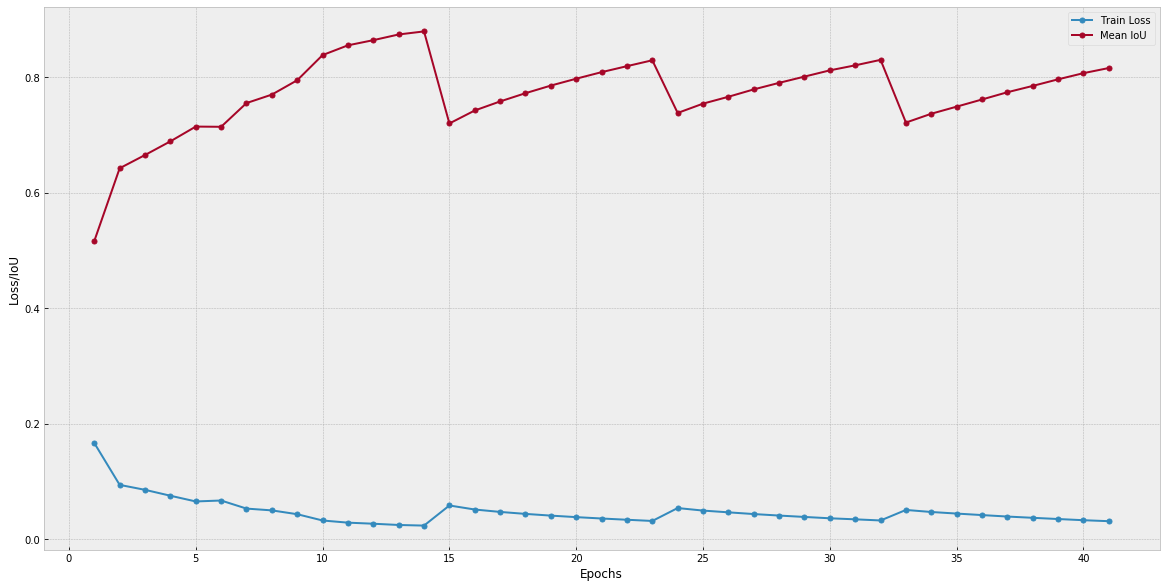

In [11]:
from keras.utils.vis_utils import plot_model


model_dict = history[0]
model_dict1 = history[1]
model_dict2 = history[2]
model_dict3 = history[3]

loss_values = model_dict['loss']
loss_values.extend(model_dict1['loss'])
loss_values.extend(model_dict2['loss'])
loss_values.extend(model_dict3['loss'])


mean_iou_values = model_dict['mean_iou']
mean_iou_values.extend(model_dict1['mean_iou'])
mean_iou_values.extend(model_dict2['mean_iou'])
mean_iou_values.extend(model_dict3['mean_iou'])
epochs_as_list = range(1, len(loss_values) +1)

print(type(epochs_as_list))

#plotting learning history
plt.figure(figsize=(20,10))
plt.style.use('bmh')

train_loss_line = plt.plot(epochs_as_list, loss_values, label = 'Train Loss' )
test_loss_line = plt.plot(epochs_as_list, mean_iou_values, label = 'Mean IoU' )

plt.setp(train_loss_line, linewidth = 2.0, marker ='o', markersize = 5.0)
plt.setp(test_loss_line, linewidth = 2.0, marker ='o', markersize = 5.0)

plt.xlabel('Epochs')
plt.ylabel('Loss/IoU')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
x = X[100]
x.shape

(256, 256, 3)

(-0.5, 255.5, 255.5, -0.5)

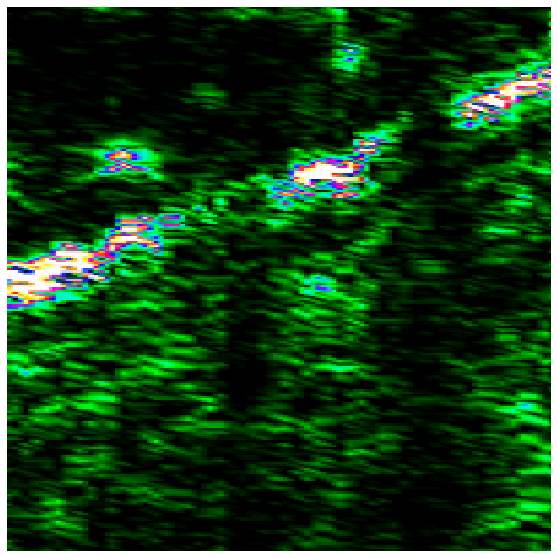

In [13]:
#image check
plt.figure(figsize=(10,10))
plt.imshow(x, cmap='gray')
plt.axis('off')


[0.0000000e+00 2.9802322e-08 5.9604645e-08 ... 9.9912053e-01 9.9914575e-01
 9.9915636e-01]


(-0.5, 255.5, 255.5, -0.5)

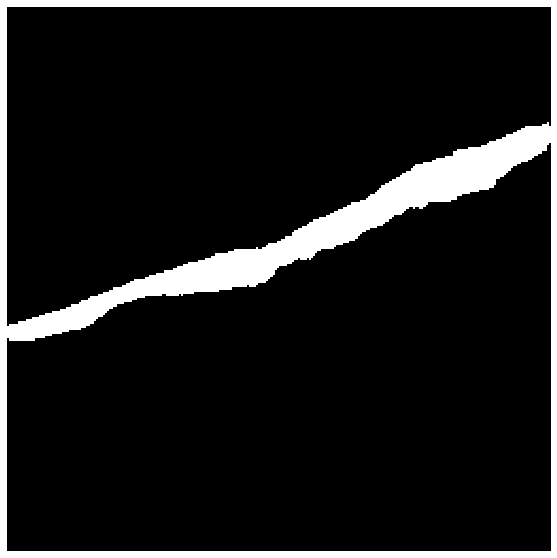

In [14]:
#network prediction of SLEB layer
x = x.reshape(1,256,256,3)
pred = model.predict(x)
pred = pred.reshape(256,256)
print(np.unique(pred))

for w in range(0,256):
    for h  in range(0,256):
        
        if pred[w,h] > 0.9: #threshold of propability matrix, range [0,1].
                            #1 is 100% sureness of network pixel belongs to SLEB layer
            pred[w,h] = 1
        else:
            pred[w,h] = 0
plt.figure(figsize=(10,10))
plt.imshow(pred, cmap='gray')
plt.axis('off')
